In [1]:
import numpy as np

In [2]:
detector_array = np.zeros((500, 500))
#this shows a 2 dimensional array with 500 cells in each direction

In [3]:
print(detector_array)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
pixel_edge_length = 15 #microns
pixel_half_length = (pixel_edge_length / 2)
number_of_pixels = 500
number_of_pixel_x = 500
number_of_pixel_y = 500
electrons_per_photon = 1500 #electrons
#center of each pixel can be calculated by multiplying it's i or j value by 15 and adding 7.5
def bottom_left_of_pixel():
    pixel_corner_i = i * pixel_edge_length
    pixel_corner_j = j * pixel_edge_length

In [5]:
#i = the row value of pixel
#j = the column value of pixel
#horz_d= horizontal distance from bottom left
#vert_d= vertical distance from bottom left
def center_of_pixel(pixel_edge_length, i, j):
    horz_d = (i * pixel_edge_length) + pixel_half_length
    vert_d = (j * pixel_edge_length) + pixel_half_length
    #print("pixel: [" + str(i) + ", " + str(j) + "], center of pixel: [" + str(horz_d) + ", " + str(vert_d) + "] microns.")
for i in range(len(detector_array)):
    for j in range(len(detector_array)):
        center_of_pixel(pixel_edge_length, i, j)   

In [6]:
import random
x_rand = random.random() * pixel_edge_length * number_of_pixels #microns
y_rand = random.random() * pixel_edge_length * number_of_pixels #microns
print("photon hit at [x,y] = [" + str(x_rand) + ", " + str(y_rand) + "] in microns")

photon hit at [x,y] = [4766.556147286584, 5030.957169524184] in microns


In [7]:
 #to do: which center of pixel(s) is closest to the random generated values
#calculate percentage of cloud in each pixel based on distance from center of multiple pixels
#strategy: attempt to make a function to calculate distance from center of circle
#to the center of each of the 4 surrounding pixels and 
#relate that number to the percentage of the circle that overlaps the pixels
#x_rand and y_rand is the center point of the circle
#sqrt((x2-x1)^2 + (y2-y1)^2)
diameter_electron_cloud = 10 #microns
radius_electron_cloud = diameter_electron_cloud / 2 #microns
area_electron_cloud = np.pi * (radius_electron_cloud ** 2)
#take x_rand and y_rand to find closest pixel(s)

In [8]:
#define detector_array_x and y
detector_array_x = np.arange(number_of_pixel_x) * pixel_edge_length + pixel_half_length
detector_array_y = np.arange(number_of_pixel_y) * pixel_edge_length + pixel_half_length
#remember multiple pixels have the same center value, but this array contains all of those possibilities

In [9]:
#redefining variables to be more precise
photon_sphere_x = x_rand #microns
photon_sphere_y = y_rand #microns
photon_sphere_z= 15
photon_sphere_microns = [photon_sphere_x, photon_sphere_y, photon_sphere_z]
photon_sphere_pixel = [photon_sphere_x / pixel_edge_length, photon_sphere_y / pixel_edge_length]
print("sphere micron position " + str(photon_sphere_microns))
print("sphere pixel position " + str(photon_sphere_pixel))


sphere micron position [4766.556147286584, 5030.957169524184, 15]
sphere pixel position [317.77040981910557, 335.3971446349456]


In [10]:
closest_pixel_x = (np.where(np.abs(detector_array_x - photon_sphere_x) == np.min(np.abs(detector_array_x - photon_sphere_x))))[0]
closest_pixel_x_microns = closest_pixel_x [0] * pixel_edge_length + pixel_half_length
closest_pixel_y = (np.where(np.abs(detector_array_y - photon_sphere_y) == np.min(np.abs(detector_array_y - photon_sphere_y))))[0]
closest_pixel_y_microns = closest_pixel_y [0] * pixel_edge_length + pixel_half_length
closest_pixel_arr = [closest_pixel_x[0], closest_pixel_y[0]]
closest_pixel_microns = [closest_pixel_x_microns, closest_pixel_y_microns]
print("closest pixel to sphere: " + str(closest_pixel_arr))
print("closest pixel's center in microns: " + str(closest_pixel_microns))
#second_closest_pixel_x =
#second_closest_pixel_y = 
#second_closest_pixel_arr = 

closest pixel to sphere: [317, 335]
closest pixel's center in microns: [4762.5, 5032.5]


In [11]:
#measure the distance from closest_pixel_microns to photon_sphere_microns in x and y directions
#all variables here are measured in microns
dist_sphere_pixel_x = np.abs(closest_pixel_x_microns - photon_sphere_x)
dist_sphere_pixel_y = np.abs(closest_pixel_y_microns - photon_sphere_y)
total_dist_sphere_pixel = np.sqrt((dist_sphere_pixel_x ** 2) + (dist_sphere_pixel_y ** 2))
print("distnace in x: " + str(dist_sphere_pixel_x) + " microns, " + "distance in y: " + str(dist_sphere_pixel_y) + " microns")
print("total distance from center of sphere to center of pixel: " + str(total_dist_sphere_pixel) + " microns")

distnace in x: 4.056147286583837 microns, distance in y: 1.5428304758161175 microns
total distance from center of sphere to center of pixel: 4.339660895458124 microns


In [12]:
#use distance values and write a if, ifelse etc statement to solve for when the circle is:
#contained within the pixel, intersected by one line (in y or x), or  intersected by 2 lines (in y and x)
electrons_per_photon = 1500 #electrons
max_dist_from_center = (pixel_edge_length - diameter_electron_cloud) / 2
if (dist_sphere_pixel_x < max_dist_from_center and dist_sphere_pixel_y < max_dist_from_center):
    print('photon contained within pixel ' + str(closest_pixel_arr))
    detector_array [closest_pixel_x, closest_pixel_y] = electrons_per_photon
elif (dist_sphere_pixel_x >= max_dist_from_center and dist_sphere_pixel_y < max_dist_from_center):
    print('photon bisected by vertical line')
#vertical line means we need to use the x distance to find the are or % of sphere that spills into next pixel
elif (dist_sphere_pixel_y >= max_dist_from_center and dist_sphere_pixel_x < max_dist_from_center):
    print('photon bisected by horizontal line')
else (dist_sphere_pixel_y >= max_dist_from_center and dist_sphere_pixel_x >= max_dist_from_center):
    
    


SyntaxError: invalid syntax (<ipython-input-12-0b766b217fa3>, line 13)

In [13]:
sm_pixel_edge_length = .5 #microns
sm_pixel_half_length = sm_pixel_edge_length/2 #microns
sm_num_of_pixels = 90
sm_third_pixels = sm_num_of_pixels / 3
sm_two_thirds_pixels = sm_num_of_pixels * (2/3)
sm_array = np.zeros ((sm_num_of_pixels, sm_num_of_pixels, sm_num_of_pixels))
sm_x_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length + (detector_array_x[closest_pixel_x] - pixel_half_length) + sm_pixel_edge_length
sm_y_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length + (detector_array_y[closest_pixel_y] - pixel_half_length) + sm_pixel_edge_length   

In [14]:
sm_x_cen

array([4755.5, 4756. , 4756.5, 4757. , 4757.5, 4758. , 4758.5, 4759. ,
       4759.5, 4760. , 4760.5, 4761. , 4761.5, 4762. , 4762.5, 4763. ,
       4763.5, 4764. , 4764.5, 4765. , 4765.5, 4766. , 4766.5, 4767. ,
       4767.5, 4768. , 4768.5, 4769. , 4769.5, 4770. , 4770.5, 4771. ,
       4771.5, 4772. , 4772.5, 4773. , 4773.5, 4774. , 4774.5, 4775. ,
       4775.5, 4776. , 4776.5, 4777. , 4777.5, 4778. , 4778.5, 4779. ,
       4779.5, 4780. , 4780.5, 4781. , 4781.5, 4782. , 4782.5, 4783. ,
       4783.5, 4784. , 4784.5, 4785. , 4785.5, 4786. , 4786.5, 4787. ,
       4787.5, 4788. , 4788.5, 4789. , 4789.5, 4790. , 4790.5, 4791. ,
       4791.5, 4792. , 4792.5, 4793. , 4793.5, 4794. , 4794.5, 4795. ,
       4795.5, 4796. , 4796.5, 4797. , 4797.5, 4798. , 4798.5, 4799. ,
       4799.5, 4800. ])

In [15]:
detector_array_x[closest_pixel_x]

array([4762.5])

In [16]:
sm_y_cen

array([5025.5, 5026. , 5026.5, 5027. , 5027.5, 5028. , 5028.5, 5029. ,
       5029.5, 5030. , 5030.5, 5031. , 5031.5, 5032. , 5032.5, 5033. ,
       5033.5, 5034. , 5034.5, 5035. , 5035.5, 5036. , 5036.5, 5037. ,
       5037.5, 5038. , 5038.5, 5039. , 5039.5, 5040. , 5040.5, 5041. ,
       5041.5, 5042. , 5042.5, 5043. , 5043.5, 5044. , 5044.5, 5045. ,
       5045.5, 5046. , 5046.5, 5047. , 5047.5, 5048. , 5048.5, 5049. ,
       5049.5, 5050. , 5050.5, 5051. , 5051.5, 5052. , 5052.5, 5053. ,
       5053.5, 5054. , 5054.5, 5055. , 5055.5, 5056. , 5056.5, 5057. ,
       5057.5, 5058. , 5058.5, 5059. , 5059.5, 5060. , 5060.5, 5061. ,
       5061.5, 5062. , 5062.5, 5063. , 5063.5, 5064. , 5064.5, 5065. ,
       5065.5, 5066. , 5066.5, 5067. , 5067.5, 5068. , 5068.5, 5069. ,
       5069.5, 5070. ])

In [17]:
sm_z_cen = np.arange(sm_num_of_pixels) * sm_pixel_edge_length

In [18]:
for i in range(sm_num_of_pixels):
    for j in range(sm_num_of_pixels):
        for k in range(sm_num_of_pixels):
            distance_to_center_of_photon = np.sqrt((sm_x_cen[i]-photon_sphere_x)**2 + \
                                                (sm_y_cen[j]-photon_sphere_y)**2 + \
                                                (sm_z_cen[k]-photon_sphere_z)**2)
            if distance_to_center_of_photon < diameter_electron_cloud/2:
                sm_array[i,j,k] = 1.

In [19]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

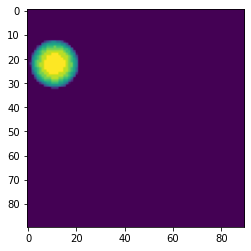

In [21]:
img = np.sum(sm_array,axis=2)
imgplot = plt.imshow(img)

In [22]:
np.sum(img)

4178.0

In [23]:
percent_pixel_1 = np.sum(img[0:int(sm_third_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_2 = np.sum(img[0:int(sm_third_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_3 = np.sum(img[0:int(sm_third_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)
percent_pixel_4 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_5 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_6 = np.sum(img[int(sm_third_pixels):int(sm_two_thirds_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)
percent_pixel_7 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), 0:int(sm_third_pixels)]) / np.sum(img)
percent_pixel_8 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), int(sm_third_pixels):int(sm_two_thirds_pixels)]) / np.sum(img)
percent_pixel_9 = np.sum(img[int(sm_two_thirds_pixels):int(sm_num_of_pixels), int(sm_two_thirds_pixels):int(sm_num_of_pixels)]) / np.sum(img)

In [24]:
print("% in first pixel: " + str(percent_pixel_1 * 100) + "%")
print("% in second pixel: " + str(percent_pixel_2 * 100) + "%")
print("% in third pixel: " + str(percent_pixel_3 * 100) + "%")
print("% in fourth pixel: " + str(percent_pixel_4 * 100) + "%")
print("% in fifth pixel: " + str(percent_pixel_5 * 100) + "%")
print("% in sixth pixel: " + str(percent_pixel_6 * 100) + "%")
print("% in seventh pixel: " + str(percent_pixel_7 * 100) + "%")
print("% in eigth pixel: " + str(percent_pixel_8 * 100) + "%")
print("% in ninth pixel: " + str(percent_pixel_9 * 100) + "%")



% in first pixel: 95.28482527525132%
% in second pixel: 0.0%
% in third pixel: 0.0%
% in fourth pixel: 4.7151747247486835%
% in fifth pixel: 0.0%
% in sixth pixel: 0.0%
% in seventh pixel: 0.0%
% in eigth pixel: 0.0%
% in ninth pixel: 0.0%


In [25]:
detector_array[closest_pixel_x,closest_pixel_y] += percent_pixel_1 * electrons_per_photon

In [26]:
electrons_pixel_1 = electrons_per_photon * percent_pixel_1
electrons_pixel_2 = electrons_per_photon * percent_pixel_2
electrons_pixel_3 = electrons_per_photon * percent_pixel_3
electrons_pixel_4 = electrons_per_photon * percent_pixel_4
electrons_pixel_5 = electrons_per_photon * percent_pixel_5
electrons_pixel_6 = electrons_per_photon * percent_pixel_6
electrons_pixel_7 = electrons_per_photon * percent_pixel_7
electrons_pixel_8 = electrons_per_photon * percent_pixel_8
electrons_pixel_9 = electrons_per_photon * percent_pixel_9
print('number of electrons in pixel 1: ' + str(electrons_pixel_1))
print('number of electrons in pixel 2: ' + str(electrons_pixel_2))
print('number of electrons in pixel 3: ' + str(electrons_pixel_3))
print('number of electrons in pixel 4: ' + str(electrons_pixel_4))
print('number of electrons in pixel 5: ' + str(electrons_pixel_5))
print('number of electrons in pixel 6: ' + str(electrons_pixel_6))
print('number of electrons in pixel 7: ' + str(electrons_pixel_7))
print('number of electrons in pixel 8: ' + str(electrons_pixel_8))
print('number of electrons in pixel 9: ' + str(electrons_pixel_9))

number of electrons in pixel 1: 1429.2723791287697
number of electrons in pixel 2: 0.0
number of electrons in pixel 3: 0.0
number of electrons in pixel 4: 70.72762087123026
number of electrons in pixel 5: 0.0
number of electrons in pixel 6: 0.0
number of electrons in pixel 7: 0.0
number of electrons in pixel 8: 0.0
number of electrons in pixel 9: 0.0
